In [1]:
%matplotlib inline
import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd
import rubisco_data

from scipy import stats
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Merge multiple measurements of the same organism by taking the median value.
merged_kin_df = rubisco_data.merge_organisms(raw_kin_df)

# Group by RuBisCO form
grouped_form = merged_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(raw_kin_df.species.unique().size, 'total unique species')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')
print(merged_kin_df.shape[0], 'data points post-merge')

378 total WT RuBisCOs
304 total unique species
208 RuBisCOs with all core kinetic data measured
305 data points post-merge


In [4]:
# vC vs kon_C
vCs = np.log(merged_kin_df.vC)
kon_Cs = np.log(merged_kin_df.kon_C)

print('Whole dataset correlation')
r, p = power_laws.log_pearsonr(vCs, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(vCs, kon_Cs))

fIs = merged_kin_df[merged_kin_df.isoform == '1']
vCs = np.log(fIs.vC)
kon_Cs = np.log(fIs.kon_C)

print('FI dataset correlation')
r, p = power_laws.log_pearsonr(vCs, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(vCs, kon_Cs))

vCs = np.log(savir_df.vC)
kon_Cs = np.log(savir_df.kon_C)

print('Savir correlation')
r, p = power_laws.log_pearsonr(vCs, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(vCs, kon_Cs))

Whole dataset correlation
Log-scale linear regression R = 0.27, P = 2.1e-05
Spearman rank correlation R = 0.12, P = 0.053
FI dataset correlation
Log-scale linear regression R = 0.13, P = 0.05
Spearman rank correlation R = 0.11, P = 0.099
Savir correlation
Log-scale linear regression R = -0.72, P = 0.00046
Spearman rank correlation R = -0.57, P = 0.012


In [5]:
all_FIs = merged_kin_df[merged_kin_df.isoform == '1']
exps, pres, rs = power_laws.bootstrap_power_law_odr(
    all_FIs.vC, all_FIs.kon_C, fraction=0.9, rounds=10000)

conf_range = [2.5, 97.5]
pre_interval = np.percentile(pres, conf_range)
exp_interval = np.percentile(exps, conf_range)
rs_interval = np.percentile(rs, conf_range)

print(exp_interval)
print(pre_interval)
print(rs_interval)

[-48.3464112   54.79876588]
[1.47570026e-29 1.18043404e+24]
[0.00627333 0.36667711]


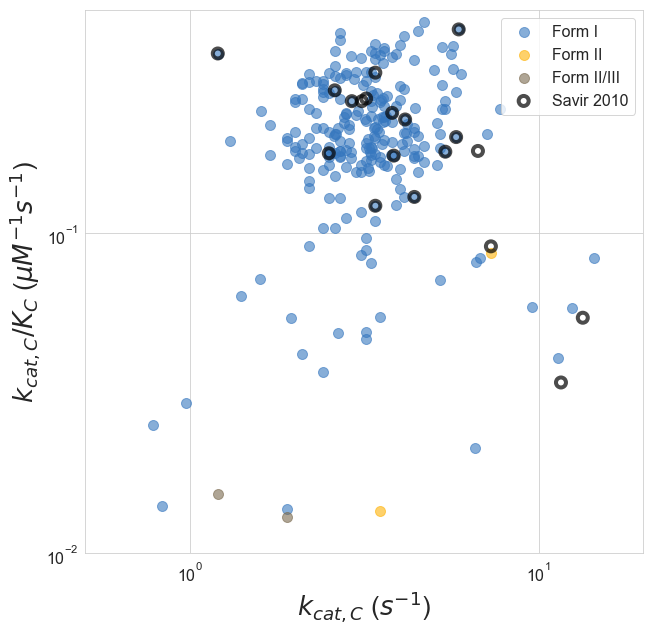

In [6]:
# Mechanistic proposal #1 from Savir - Vc vs. k_onC color by isoform
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

for i, (group, gdf) in enumerate(grouped_form):
    if group == '3':
        continue
        
    label = 'Form %s' % groups[group]
    c = matplotlib.colors.rgb2hex(named_colors[i])
    plt.scatter(gdf.vC, gdf.kon_C, c=[c], s=100, label=label, alpha=0.6)

# Savir 2010 says konC = vc/KC = vc/(1.32*vc^2) = 0.757/vc
xs = np.arange(0.1, 20, 0.1)
projected_konC = 0.757/xs
#plt.plot(xs, projected_konC, ls='--', lw=2, c='grey')

# plot our own fit of the F1 enzymes
# Plot regression of S vs vC
xs = np.arange(1e-1, 20, 0.01)
all_FIs = raw_kin_df[raw_kin_df.isoform == '1']
konCs = np.log(all_FIs.kon_C)
vCs = np.log(all_FIs.vC)
exp_FI, pre_FI, _ = power_laws.fit_power_law_odr(vCs, konCs)
#plt.plot(xs, np.power(xs, exp_FI) * pre_FI, ls='--', c=named_colors[0], lw=4)

# Show savir data with an outline
plt.scatter(savir_df.vC, savir_df.kon_C, c='None', edgecolors='k',
            linewidths=4, s=100, label='Savir 2010', alpha=0.7, zorder=10)


plt.legend(loc=1, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,C}$ ($s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-2, 0.5)
plt.xlim(0.5, 20)

plt.savefig('fig5/fig5_konC_kcatC_FI.png', dpi=600)
plt.savefig('fig5/fig5_konC_kcatC_FI.svg')

plt.show()

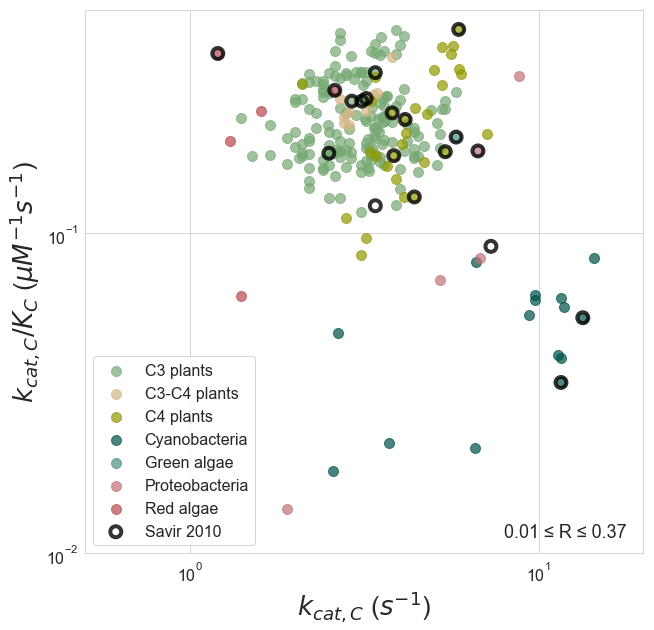

In [7]:
# Mechanistic proposal #1 from Savir - Vc vs. k_onC color by host physiology
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

F1_data = raw_kin_df[raw_kin_df.isoform == '1']
F2_data = raw_kin_df[raw_kin_df.isoform == '2']

group_mapping = {'C3 plants': 'C3 plants',
                 'C3-C4 plants': 'C3-C4 plants',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 'Green algae': 'Green algae',
                 'Red algae': 'Red algae',
                 'Alphaproteobacteria': 'Proteobacteria',
                 'Betaproteobacteria': 'Proteobacteria',
                 'Gammaproteobacteria': 'Proteobacteria',
                }
color_mapping = {
    'C3 plants': 'dusty green',
    'C3-C4 plants': 'very light brown',
    'C4 plants': 'pea soup',
    'Cyanobacteria': 'dark blue green',
    'Green algae': 'dusty teal',
    'Red algae': 'dusty red',
    'Proteobacteria': 'dusty rose',
}
grouped_taxa = F1_data.set_index('taxonomy').groupby(group_mapping)

for i, (group, gdf) in enumerate(grouped_taxa):
    cname = color_mapping[group]
    c = seaborn.xkcd_rgb[cname]
    plt.scatter(gdf.vC, gdf.kon_C, c=c, s=100, label=group, alpha=0.7)

# Show savir data with an outline
plt.scatter(savir_df.vC, savir_df.kon_C, c='None', edgecolors='k',
            linewidths=4, s=120, label='Savir 2010', alpha=0.8, zorder=10)
plt.text(0.75, 0.03, u'%.2f ≤ R ≤ %.2f' % (rs_interval[0], rs_interval[1]), 
         transform=figure.axes[0].transAxes, fontsize=18)
    
plt.legend(loc=3, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,C}$ ($s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-2, 0.5)
plt.xlim(0.5, 20)

plt.savefig('fig5/fig5_konC_kcatC_FI_by_group.png', dpi=600)
plt.savefig('fig5/fig5_konC_kcatC_FI_by_group.svg')

plt.show()